## Quantization, Making Models Smaller and Inference Faster

Quantization is a technique used in the optimization of large language models (LLMs). It reduces the precision of the model's parameters, effectively shrinking its size and computational requirements, while aiming to maintain its performance. The main approaches to quantization are:

- **Post-Training Static Quantization**: Converts model weights to a lower precision (e.g., from 32-bit floating-point to 8-bit integer) before inference. This approach requires a calibration set per dimension to determine optimal quantization parameters, namely scaling-factors and zero-point. It's typically faster but may result in some accuracy loss.
- 
- **Post-Training Dynamic Quantization**: Quantizes weights on-the-fly during inference. Unlike static quantization, this method doesn't require a separate calibration step, making it more flexible in deployment. Although it's slightly slower than static quantization, it often preserves more of the model's original accuracy. 
- 
- **Quantization-Aware Training**: Applies additional training to simulate the effects of quantization by rounding float32 values. This allows the model to learn (update the model parameters) to minimize the final loss considering quantization. As a result, it generally achieves the best balance of model size reduction and accuracy preservation. However, it comes with the drawback of requiring a complete retraining of the model (end-to-end forward/backward propagation).

In this notebook, we introduce how quantization works specifically for LLMs, demonstrating its practical implementation and benchmarking in terms of model size, latency, and accuracy.

In [1]:
%pip install transformers datasets evaluate --quiet | tail -n 1

Note: you may need to restart the kernel to use updated packages.


### 1. Load BERT Transformer Model

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [7]:
query = """I need to book a flight from New York to Tokyo for next month in economy class"""
pipe(query)

[{'label': 'book_flight', 'score': 0.5934060215950012}]

### 2. Prepare Performance Benchmark: Size, Latency, and Accuracy

In this section, we'll create a benchmark to evaluate a model across three key metrics: model performance, latency, and size. **Model performance** will be assessed using accuracy. **Latency** will be measured as the average time taken to generate responses. And **Model size** will be quantified in terms of the number of parameters and the disk space required for storage. By combining these metrics, we aim at allowing informed comparisons and trade-off analyses between a baseline model before and after quantization.

In [44]:
import evaluate
import torch
import numpy as np

from pathlib import Path
from time import perf_counter
from typing import Dict, Any

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT Baseline", num_latency_runs=100, accuracy_sample_size=None):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        self.num_latency_runs = num_latency_runs
        self.accuracy_sample_size = accuracy_sample_size

    def compute_size(self) -> Dict[str, float]:
      """Compute the size of the model (MB)."""
      tpm_path = Path("temp.p")
      torch.save(self.pipeline.model.state_dict(), tpm_path)
      size_mb = Path(tpm_path).stat().st_size / (1024 ** 2)
      tpm_path.unlink()
      return {"size_mb": size_mb}

    def compute_latency(self) -> Dict[str, float]:
      """Compute the average latency of the model."""
      latencies = [self._inference_time() for _ in range(self.num_latency_runs)]
      time_avg_ms = 1000 * np.mean(latencies)
      time_std_ms = 1000 * np.std(latencies)
      return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def compute_accuracy(self) -> Dict[str, float]:
      """Compute the accuracy of the model on the dataset."""
      accuracy_metric = evaluate.load("accuracy")
      intents = self.dataset.features["intent"]
        
      dataset = self.dataset
      if self.accuracy_sample_size:
          dataset = self.dataset.select(range(self.accuracy_sample_size))

      x = [_["text"] for _ in dataset]
      y = [_["intent"] for _ in dataset]

      preds = [intents.str2int(self._predict(text)) for text in x]
      return accuracy_metric.compute(predictions=preds, references=y)
    
    def run_benchmark(self):
      metrics = {self.optim_type: {}}
      metrics[self.optim_type].update(self.compute_size())
      metrics[self.optim_type].update(self.compute_latency())
      metrics[self.optim_type].update(self.compute_accuracy())
      self._print(metrics[self.optim_type])
      return metrics

    def _inference_time(self) -> float:
      t1 = perf_counter()
      _ = self.pipeline(self.dataset[42]["text"]) # we use always the same sample
      t2 = perf_counter()
      return t2 - t1

    def _predict(self, text: str) -> str:
      return self.pipeline(text)[0]["label"]
    
    @staticmethod
    def _print(metrics: Dict[str, Any]) -> None:
      print(f"Model size (MB): {metrics['size_mb']:.2f}")
      print(f"Average latency (ms): {metrics['time_avg_ms']:.2f} ± {metrics['time_std_ms']:.2f}")
      print(f"Accuracy on test set: {metrics['accuracy']:.3f}")

### 3. Evaluate Model before Quantization

In [10]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [11]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB): 418.08
Average latency (ms): 65.75 ± 8.92
Accuracy on test set: 0.867


### 4. Dynamic Quantization

We call `torch.quantization.quantize_dynamic` on the model to apply dynamic quantization on the HuggingFace BERT model. Specifically, we specify that we want the `torch.nn.Linear` modules in our model to be quantized; and the weights to be converted to quantized `int8` values.

In [12]:
from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu")
model_dynamic_quantized = quantize_dynamic(
    model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8
)

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
pipe = pipeline("text-classification", model=model_dynamic_quantized, tokenizer=tokenizer)

### 5. Evaluate Model after Quantization

In [45]:
optim_type = "Dynamic Quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB): 173.18
Average latency (ms): 20.45 ± 2.73
Accuracy on test set: 0.864


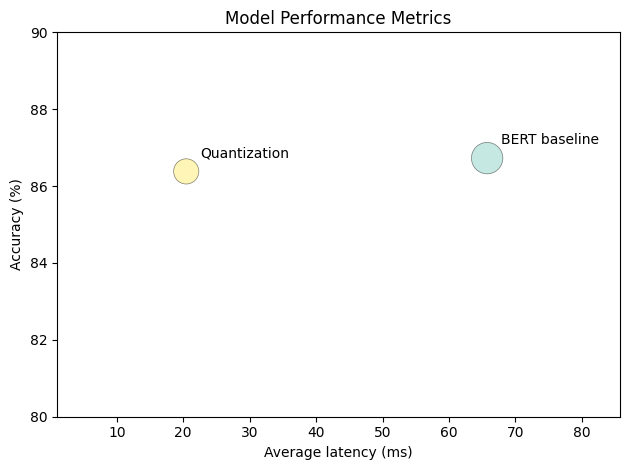

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_metrics(perf_metrics, y_min=80, y_max=90, x_padding=20):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    
    fig, ax = plt.subplots()
    sizes = np.sqrt(df["size_mb"]) * 25  # Scale sizes for better visibility
    
    scatter = ax.scatter(df["time_avg_ms"], df["accuracy"] * 100,
                         s=sizes, alpha=0.5, c=range(len(df)), cmap='Set3', edgecolors='black', linewidth=0.5)
    
    # Add labels
    for idx, row in df.iterrows():
        ax.annotate(idx, (row["time_avg_ms"], row["accuracy"] * 100),
                    xytext=(10, 10), textcoords='offset points') 
    
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(1, df["time_avg_ms"].max() + x_padding)
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Average latency (ms)")
    ax.set_title("BERT (Quantized) Models: Performance Metrics")
    
    plt.tight_layout()
    plt.show()

plot_metrics(perf_metrics)

In [47]:
perf_metrics

{'BERT baseline': {'size_mb': 418.0845603942871,
  'time_avg_ms': 65.74521105004351,
  'time_std_ms': 8.916220711214512,
  'accuracy': 0.8672727272727273},
 'Quantization': {'size_mb': 173.18227100372314,
  'time_avg_ms': 20.446120749975307,
  'time_std_ms': 2.7305180840732897,
  'accuracy': 0.8638181818181818}}